## Pneumonia Detection from Chest X-Rays 

When it comes to pneumonia, chest X-rays are the best available method for diagnosis. More than 1 million adults are hospitalized with pneumonia and around 50,000 die from the disease every year in the US alone. The high prevalence of pneumonia makes it a good candidate for the development of a deep learning application for two reasons: 
1. Data availability in a high enough quantity for training deep learning models for image classification 
2. Opportunity for clinical aid by providing higher accuracy image reads of a difficult-to-diagnose disease and/or reduce clinical burnout by performing automated reads of very common scans. 

The diagnosis of pneumonia from chest X-rays is difficult for several reasons: 

The appearance of pneumonia in a chest X-ray can be very vague depending on the stage of the infection 

Pneumonia often overlaps with other diagnoses 

Pneumonia can mimic benign abnormalities 

For these reasons, common methods of diagnostic validation performed in the clinical setting are to obtain sputum cultures to test for the presence of bacteria or viral bodies that cause pneumonia, reading the patient's clinical history and taking their demographic profile into account, and comparing a current image to prior chest X-rays for the same patient if they are available.

The dataset provided by the NIH specifically to address the problem of a lack of large x-ray datasets with ground truth labels to be used in the creation of disease detection algorithms. 

The data can be downloade from the [kaggle website](https://www.kaggle.com/nih-chest-xrays/data)

There are 112,120 X-ray images with disease labels from 30,805 unique patients in this dataset. The disease labels were created using Natural Language Processing (NLP) to mine the associated radiological reports. The labels include 14 common thoracic pathologies: 

- Atelectasis 
- Consolidation 
- Infiltration 
- Pneumothorax 
- Edema 
- Emphysema 
- Fibrosis 
- Effusion 
- Pneumonia 
- Pleural thickening 
- Cardiomegaly 
- Nodule 
- Mass 
- Hernia 

The biggest limitation of this dataset is that image labels were NLP-extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%. 

The original radiology reports are not publicly available but you can find more details on the labeling process [here](https://arxiv.org/abs/1705.02315). 

Dataset Contents: 

112,120 frontal-view chest X-ray PNG images in 1024*1024 resolution (under images folder) 

Meta data for all images (Data_Entry_2017.csv): Image Index, Finding Labels, Follow-up #, Patient ID, Patient Age, Patient Gender, View Position, Original Image Size and Original Image Pixel Spacing. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
from skimage.io import imread, imshow
from itertools import chain
import sklearn.model_selection as skl_ms
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, matthews_corrcoef

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
46800,00011945_002.png,No Finding,2,11945,33,F,AP,2500,2048,0.168000,0.168000,NaN,/data/images_006/images/00011945_002.png
110802,00030203_000.png,No Finding,0,30203,29,F,PA,2020,2021,0.194311,0.194311,NaN,/data/images_012/images/00030203_000.png
57000,00014153_002.png,Effusion|Mass,2,14153,35,F,PA,2992,2991,0.143000,0.143000,NaN,/data/images_007/images/00014153_002.png


### Change columns names in all_xray_df, thus the names will be readable (similar to sample_df) and remove 'Unnamed: 11' column.

In [3]:
sample_df = pd.read_csv('sample_labels.csv')
final_df = all_xray_df.drop('Unnamed: 11', 1)
col_names_ls = list(sample_df.columns)
col_names_ls.append('path')
final_df.columns = col_names_ls
display(final_df.info())
final_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImageWidth           112120 non-null  int64  
 8   OriginalImageHeight          112120 non-null  int64  
 9   OriginalImagePixelSpacing_x  112120 non-null  float64
 10  OriginalImagePixelSpacing_y  112120 non-null  float64
 11  path                         112120 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 10.3+ MB


None

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
108575,00029459_001.png,No Finding,1,29459,52,M,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00029459_001.png
6739,00001811_000.png,No Finding,0,1811,42,M,PA,2500,2048,0.171000,0.171000,/data/images_002/images/00001811_000.png
84018,00020654_005.png,No Finding,5,20654,22,M,PA,2992,2797,0.143000,0.143000,/data/images_009/images/00020654_005.png
71579,00017635_007.png,No Finding,7,17635,41,F,AP,2500,2048,0.168000,0.168000,/data/images_008/images/00017635_007.png
111530,00030523_002.png,No Finding,2,30523,34,M,AP,3056,2544,0.139000,0.139000,/data/images_012/images/00030523_002.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*final_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        final_df[c_label] = final_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
final_df.sample(5)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
44044,00011355_045.png,Mass|Pneumothorax,45,11355,28,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
34466,00009072_000.png,No Finding,0,9072,59,M,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
82359,00020261_001.png,No Finding,1,20261,42,F,PA,1686,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6845,00001836_031.png,Atelectasis|Consolidation|Infiltration|Mass,31,1836,49,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
109518,00029808_006.png,Cardiomegaly,6,29808,32,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
final_df['pneumonia_class'] = final_df['Pneumonia'].astype(int)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImageWidth           112120 non-null  int64  
 8   OriginalImageHeight          112120 non-null  int64  
 9   OriginalImagePixelSpacing_x  112120 non-null  float64
 10  OriginalImagePixelSpacing_y  112120 non-null  float64
 11  path                         112120 non-null  object 
 12  Atelectasis                  112120 non-null  float64
 13 

## Create your training and testing data:

In [6]:
def create_splits(df, class_name, test_size=0.2, random_state=None):
    '''
    df: dataframe
    class_name: str, the binary class column
    test_size: float, the proportion of the dataset to include in the test split
    random_staat: None or int     
    '''
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = skl_ms.train_test_split(df, test_size = test_size, random_state = random_state, 
                                             stratify = df[class_name])
        
    return train_data, val_data

In [7]:
train_df_init, val_df_init = create_splits(final_df, 'pneumonia_class', 0.2, 1)
train_frac_init = train_df_init['pneumonia_class'].mean()
valid_frac_init = val_df_init['pneumonia_class'].mean()
print(f'The "pneumonia_class" positive cases: \ntrain: {train_frac_init*100:.2f}% \nvalidation: {valid_frac_init*100:.2f}%')

The "pneumonia_class" positive cases: 
train: 1.28% 
validation: 1.28%


### The 1.28% of positive cases in train and validation datasets are too less to train a model. One of the solutions is to downsample the majority class. Fully balanced dataset (50/50 - positive/negative cases) is good for training. 20% of positive cases is a good fraction for model validation because of this is a typical ration in clinic.

In [8]:
# function to downsample majority calass 
def downsample(df, col_name, frac_minor = 0.2, random_state = 1):
    '''
    will return a new downsapled dataframe with the minority calass fraction of frac_minor 
    and the chosen column col_name
    '''
    # Separate majority and minority classes
    df_major = df[df[col_name] == 0]
    df_minor = df[df[col_name] == 1]
    n_samples = int((1. - frac_minor)/ frac_minor) * len(df_minor)
    # Downsample majority class
    df_major_down = resample(df_major, 
                                 replace=False,    # sample without replacement
                                 n_samples=n_samples,     # to match minority class
                                 random_state=random_state) # reproducible results
    # Combine minority class with downsampled majority class
    df_down = pd.concat([df_major_down, df_minor])
    return df_down

In [9]:
train_df = downsample(train_df_init, 'pneumonia_class', 0.5)
val_df = downsample(val_df_init, 'pneumonia_class', 0.2)
train_frac = train_df['pneumonia_class'].mean()
valid_frac = val_df['pneumonia_class'].mean()
print(f'The "pneumonia_class" positive cases: \ntrain: {train_frac*100:.2f}% \nvalidation: {valid_frac*100:.2f}%')

The "pneumonia_class" positive cases: 
train: 50.00% 
validation: 20.00%


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [10]:
def my_image_augmentation(h_shift = 0.1, w_shift = 0.1, rotation = 10, shear = .1, zoom = 0.1, train=True):
    '''
    Image augmentation helper
    The default parameters are good for augmenting medical images
    The default parameters can be used for training data augmentation (train=True is default)
    For validation dataset only rescale have to be applied (train=False)
    
    '''
    if train:
        my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range = h_shift, 
                                  width_shift_range = w_shift, 
                                  rotation_range = rotation, 
                                  shear_range = shear,
                                  zoom_range = zoom
                            )
    else:
         my_idg = ImageDataGenerator(rescale=1. / 255.0)       
    return my_idg


def make_train_gen(train_df, aug=my_image_augmentation, img_size=(224,224), batch_size=64):
    '''
    Train image generator
    train_df: traing dataset
    train_idg: augmentation helper, default is 
    my_image_augmentation(h_shift = 0.1, w_shift = 0.1, rotation = 10, shear = .1, zoom = 0.1, train=True)
    img_size: size of the images, the default is (224,224), can be used for VGG16
    batch_size: batch size, default is 16
    
    '''
    train_idg = aug()
    train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col ='path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size, 
                                         batch_size = batch_size
                                         )
    return train_gen


def make_val_gen(valid_df, aug=my_image_augmentation, img_size=(224,224), batch_size=512):
    '''
    Train image generator
    valid_df: traing dataset
    val_idg: augmentation helper, default is rescale only my_image_augmentation(train=False)
    img_size: size of the images, the default is (224,224), can be used for VGG16
    batch_size: batch size, default is 128
    
    '''
    val_idg=aug(train=False)
    val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col ='path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size, 
                                         batch_size = batch_size
                                         )                              
    return val_gen

In [11]:
# need to have strings in the class
train_df['pneumonia_class'] = train_df['pneumonia_class'].astype(str)
val_df['pneumonia_class'] = val_df['pneumonia_class'].astype(str)
# apply generators
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(val_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

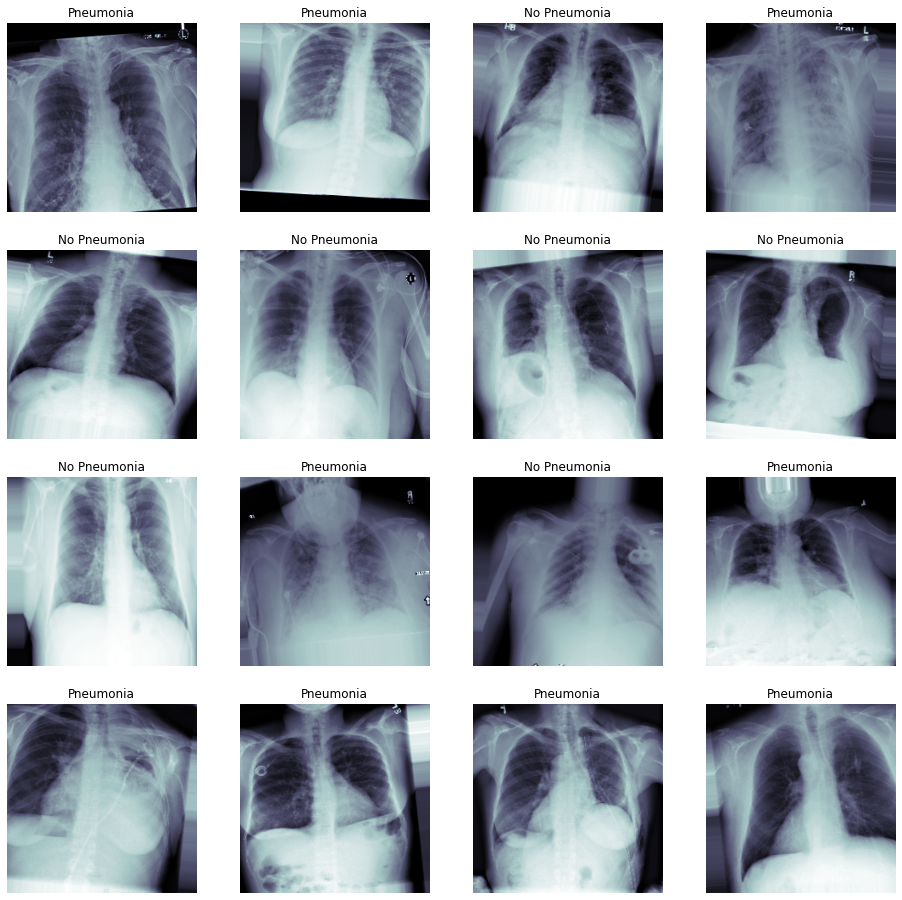

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [14]:
def load_pretrained_model(lay_of_interest='block5_pool'):
    '''
    VGG16 model
    output transfer layer 'block5_pool' is a default
    '''
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    print(f'There are total {len(vgg_model.layers)} layers in our VGG model')
    vgg_model.layers
    return vgg_model

In [15]:
def build_my_model(pretrained_model):
    '''
    We start with a pretrained VGG16 model
    '''
    for layer in pretrained_model.layers[0:-4]:
        layer.trainable = False
    
    print('Pre-trained layers info:')
    for layer in pretrained_model.layers:
        print(layer.name, layer.trainable)
    
    my_model = Sequential()
    # Add the convolutional part of the VGG16 model - pretrained_model
    my_model.add(pretrained_model)
    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    my_model.add(Flatten())
    # Add several fully-connected layers with dropout
    my_model.add(Dropout(0.2))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(64, activation='relu'))
    my_model.add(Dropout(0.2))
    # Final output layer:
    my_model.add(Dense(1, activation='sigmoid'))
    return my_model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [16]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=15)

reduce_l_rate = ReduceLROnPlateau(monitor='val_loss',
                                  verbose=1, 
                                  factor=0.5,
                                  patience=3,
                                  min_lr=1e-7)

callbacks_list = [checkpoint, reduce_l_rate, early]

### Start training! 

In [17]:
## Load VGG16
my_vgg16 = load_pretrained_model()
my_vgg16.summary()

There are total 19 layers in our VGG model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (Max

In [18]:
## built my model
my_model = build_my_model(my_vgg16)
## Set our optimizer, loss function, learning rate, and compile
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
my_model.summary()

Pre-trained layers info:
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
____________

In [19]:
## train your model
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 100, 
                          callbacks = callbacks_list)

Epoch 1/100
36/36 [==============================] - 64s 2s/step - loss: 0.7081 - binary_accuracy: 0.5140 - val_loss: 0.7041 - val_binary_accuracy: 0.4570

Epoch 00001: val_loss improved from inf to 0.70410, saving model to xray_class_my_model.best.hdf5
Epoch 2/100
36/36 [==============================] - 59s 2s/step - loss: 0.6827 - binary_accuracy: 0.5598 - val_loss: 0.7662 - val_binary_accuracy: 0.2930

Epoch 00002: val_loss did not improve from 0.70410
Epoch 3/100
36/36 [==============================] - 60s 2s/step - loss: 0.6709 - binary_accuracy: 0.5895 - val_loss: 0.7235 - val_binary_accuracy: 0.5273

Epoch 00003: val_loss did not improve from 0.70410
Epoch 4/100
36/36 [==============================] - 58s 2s/step - loss: 0.6568 - binary_accuracy: 0.6210 - val_loss: 0.5996 - val_binary_accuracy: 0.6445

Epoch 00004: val_loss improved from 0.70410 to 0.59957, saving model to xray_class_my_model.best.hdf5
Epoch 5/100
36/36 [==============================] - 59s 2s/step - loss: 0

In [20]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

### Let's look at the performance of the model by plotting performance statistics

In [21]:
## all validation dataset
val_gen_all = make_val_gen(val_df, batch_size=1430)
valX_all, valY_all = val_gen_all.next()

Found 1430 validated image filenames belonging to 2 classes.


In [22]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX_all, batch_size = 32, verbose = True)

1430/1430 [==============================] - 19s 13ms/step


In [23]:
def plot_roc_curve(ground_truth, probability, legend='Pneumonia', f_name='roc_pheumonia.png'):
    '''
    This fucntions accepts imputs:
    ground_truth: list, array, or data series 
    probability: list, array, or data series
    It plots ROC curve and calculates AUC
    '''
    fpr, tpr, _ = roc_curve(ground_truth, probability)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', 
             lw=2, label=f'{legend} (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc=4)
    plt.savefig(f_name)
    plt.show()
    return

# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(ground_truth, probability, legend='Pneumonia', f_name='pr_rec_pheumonia.png'):
    '''
    This fucntions accepts imputs:
    ground_truth: list, array, or data series 
    probability: list, array, or data series
    It plots Precision-Recall curve and caclulates average precision-recall score
    '''
    average_precision = average_precision_score(ground_truth, probability)
    precision, recall, _ = precision_recall_curve(ground_truth, probability)
    plt.figure(figsize=(5, 5))
    plt.plot(recall, precision, color='darkblue', 
             lw=2, label=f'{legend} (AP score: {average_precision:0.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve')
    plt.legend(loc=3)
    plt.savefig(f_name)
    plt.show()
    return
    
# function to calculate the F1 score
def  calc_f1(prec,recall):
    '''
    This function accepts inputs:
    precision and recall values
    and return calculated f1-score
    '''
    return 2*(prec*recall)/(prec+recall)

# function to plot F1 scores by threshold
def plot_f1(ground_truth, probability, legend='Pneumonia', f_name='F1_score.png'):
    '''
    This fucntions accepts imputs:
    ground_truth: list, array, or data series 
    probability: list, array, or data series
    It plots precision, recall, thresholds, F1-scores
    and return calculated f1_scores
    '''
    precision, recall, thresholds = precision_recall_curve(ground_truth, probability)
    f1_scores = calc_f1(precision, recall)
    plt.plot(thresholds, f1_scores[0:-1], label='F1-score')
    plt.xlabel('Thresholds')
    plt.ylabel('F1 scores')
    plt.title(f'F1 scores by thresholds')
    plt.legend(loc=0)
    plt.savefig(f_name)
    plt.show()    
    return precision, recall, thresholds, f1_scores
   
#Also consider plotting the history of your model training:

def plot_history(history, f_name='hist_pneumonia.png'):
    
    x = range(len(history['val_loss']))
    fig, axs= plt.subplots(1, 2, figsize=(14,7))
    fig.suptitle('Training history plots')
    axs[0].plot(x, history['loss'], color='r', label='train loss')
    axs[0].plot(x, history['val_loss'], color='b', label='valid loss')
    axs[0].set_title('Trainin/validation loss')
    axs[0].legend(loc=0)
    axs[1].plot(x, history['binary_accuracy'], color='r', label='train acc')
    axs[1].plot(x, history['val_binary_accuracy'], color='b', label='valid acc')
    axs[1].set_title('Trainin/validation accuracy')
    axs[1].legend(loc=0)
    plt.savefig(f_name)
    plt.show()
    return

In [24]:
## read history from file
history_df = pd.read_csv('history.csv')

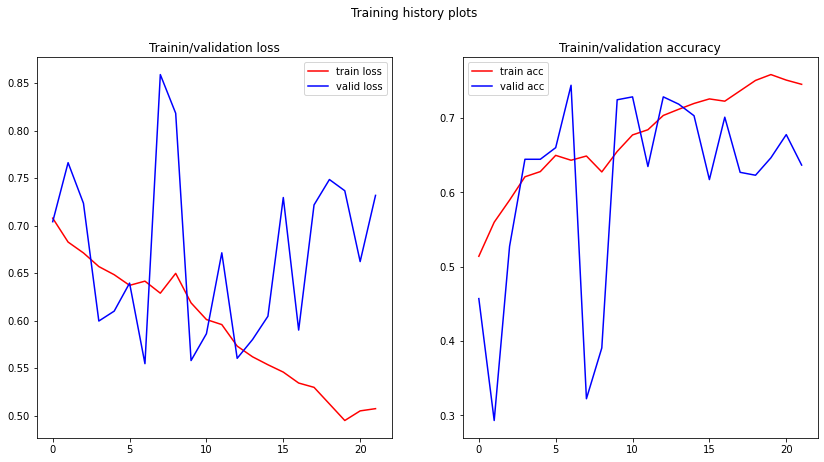

In [25]:
plot_history(history_df)

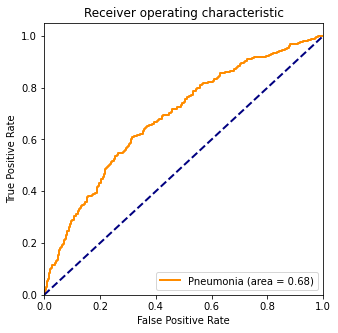

In [26]:
plot_roc_curve(valY_all, pred_Y)

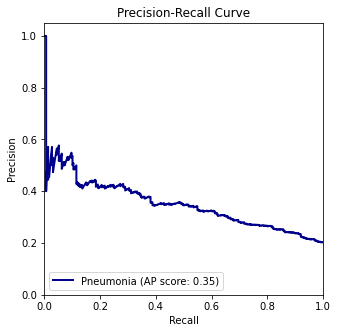

In [27]:
plot_precision_recall_curve(valY_all, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

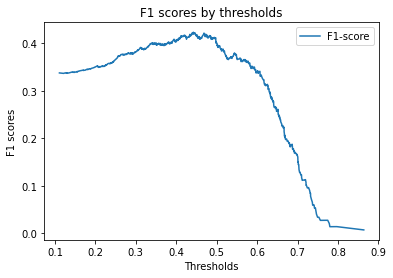

In [28]:
precision, recall, thresholds, f1_scores = plot_f1(valY_all, pred_Y)

### Matthews correlation coefficient

The [Matthew’s correlation coefficient (MCC)](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) is a good measure of model quality for binary classes. Quoting Wikipedia:

“The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.”

<br/>

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>M</mi>
  <mi>C</mi>
  <mi>C</mi>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mi>t</mi>
      <mi>p</mi>
      <mo>&#xD7;</mo>
      <mi>t</mi>
      <mi>n</mi>
      <mo>&#x2212;</mo>
      <mi>f</mi>
      <mi>p</mi>
      <mo>&#xD7;</mo>
      <mi>f</mi>
      <mi>n</mi>
    </mrow>
    <msqrt>
      <mo stretchy="false">(</mo>
      <mi>t</mi>
      <mi>p</mi>
      <mo>+</mo>
      <mi>f</mi>
      <mi>p</mi>
      <mo stretchy="false">)</mo>
      <mo stretchy="false">(</mo>
      <mi>t</mi>
      <mi>p</mi>
      <mo>+</mo>
      <mi>f</mi>
      <mi>n</mi>
      <mo stretchy="false">)</mo>
      <mo stretchy="false">(</mo>
      <mi>t</mi>
      <mi>n</mi>
      <mo>+</mo>
      <mi>f</mi>
      <mi>p</mi>
      <mo stretchy="false">)</mo>
      <mo stretchy="false">(</mo>
      <mi>t</mi>
      <mi>n</mi>
      <mo>+</mo>
      <mi>f</mi>
      <mi>n</mi>
      <mo stretchy="false">)</mo>
    </msqrt>
  </mfrac>
  <mo>.</mo>
</math>

MCC takes into account all four values in the confusion matrix, and a high value (close to 1) means that both classes are predicted well, even if one class is disproportionately under- (or over-) represented.

In [29]:
metrics_df = pd.DataFrame({'thresholds':thresholds, 'precision':precision[:-1], 'recall':recall[:-1], 'f1_scores':f1_scores[:-1]})
metrics_df['matthews_corrcoef']= metrics_df['thresholds'].apply(lambda x: matthews_corrcoef(valY_all, pred_Y >= x))
metrics_df.to_csv('metrics.csv')
metrics_df.describe()

,thresholds,precision,recall,f1_scores,matthews_corrcoef
count,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000
mean,0.405260,0.306648,0.642853,0.359689,0.178936
std,0.155917,0.085768,0.275526,0.072783,0.049056
min,0.111182,0.202559,0.003497,0.006969,0.029617
25%,0.283403,0.240750,0.430070,0.350604,0.154702
50%,0.389657,0.282470,0.695804,0.378963,0.196008
75%,0.512995,0.351443,0.888112,0.400399,0.215914
max,0.863921,1.000000,1.000000,0.423358,0.244158


In [30]:
metrics_df = pd.read_csv('metrics.csv')

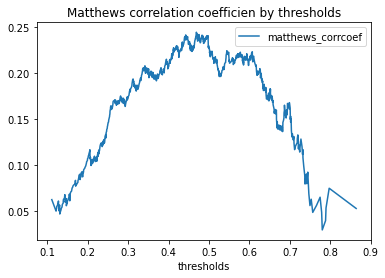

In [31]:
metrics_df.plot('thresholds', 'matthews_corrcoef')
plt.title('Matthews correlation coefficien by thresholds')
plt.savefig('matthews_corrcoef.png')
plt.show()

### I am going to use Matthews correlation coefficient to define the best threshold due to it takes into account all four values in the confusion matrix

In [32]:
## Find the threshold that optimize your model's performance,
## and use that threshold to makae binary classification. Make sure you take all your metrics into consideration.
max_metrics_loc = metrics_df.idxmax(axis = 0, skipna = True)
max_ind_f1 = max_metrics_loc.loc['f1_scores']
max_ind_mcc = max_metrics_loc.loc['matthews_corrcoef']
print('\nMCC maximizing values')
print(f"Maximum MCC is {metrics_df['matthews_corrcoef'].iloc[max_ind_mcc]:0.3f} at threshold = {metrics_df['thresholds'].iloc[max_ind_mcc]:.3f}")
print(f"Maximum F1-score is {metrics_df['f1_scores'].iloc[max_ind_mcc]:0.3f} at best MCC threshold of {metrics_df['thresholds'].iloc[max_ind_mcc]:.3f}") 
print(f"Precision is {metrics_df['precision'].iloc[max_ind_mcc]:0.3f} at best MCC threshold of {metrics_df['thresholds'].iloc[max_ind_mcc]:.3f}")
print(f"Recall is {metrics_df['recall'].iloc[max_ind_mcc]:0.3f} at best MCC threshold of {metrics_df['thresholds'].iloc[max_ind_mcc]:.3f}") 

print('\nF1-score maximizing values')
print(f"Maximum F1-score is {metrics_df['f1_scores'].iloc[max_ind_f1]:0.3f} at threshold = {metrics_df['thresholds'].iloc[max_ind_f1]:.3f}")  
print(f"Maximum MCC is {metrics_df['matthews_corrcoef'].iloc[max_ind_f1]:0.3f} at best F1-socre threshold of {metrics_df['thresholds'].iloc[max_ind_f1]:.3f}")   
print(f"Precision is {metrics_df['precision'].iloc[max_ind_f1]:0.3f} at best F1-socre threshold of {metrics_df['thresholds'].iloc[max_ind_f1]:.3f}")
print(f"Recall is {metrics_df['recall'].iloc[max_ind_f1]:0.3f} at best F1-socre threshold of {metrics_df['thresholds'].iloc[max_ind_f1]:.3f}") 

# compute predictions at a threshold for the best MCC
pred_Y_thr_MCC_best = (pred_Y >= metrics_df['thresholds'].iloc[max_ind_mcc]).astype(float).ravel()
MCC_best = metrics_df['thresholds'].iloc[max_ind_mcc]


MCC maximizing values
Maximum MCC is 0.244 at threshold = 0.469
Maximum F1-score is 0.421 at best MCC threshold of 0.469
Precision is 0.342 at best MCC threshold of 0.469
Recall is 0.549 at best MCC threshold of 0.469

F1-score maximizing values
Maximum F1-score is 0.423 at threshold = 0.442
Maximum MCC is 0.241 at best F1-socre threshold of 0.442
Precision is 0.325 at best F1-socre threshold of 0.442
Recall is 0.608 at best F1-socre threshold of 0.442


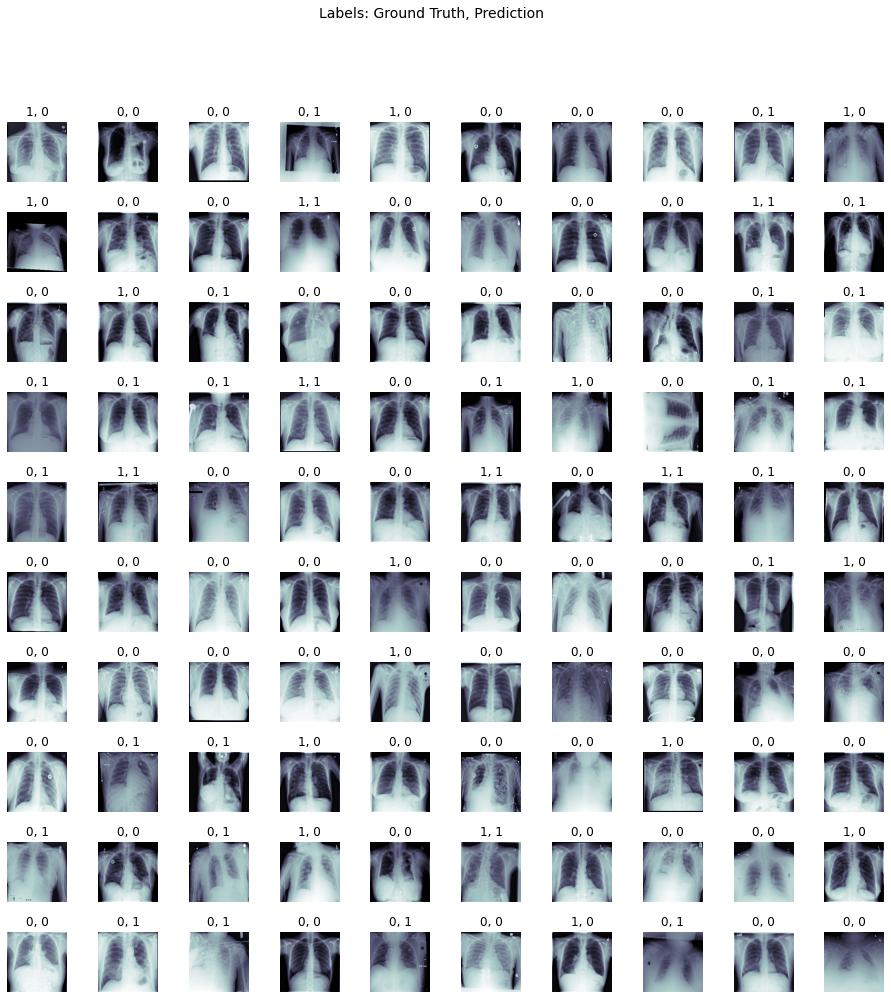

In [33]:
## Let's look at some examples of true vs. predicted with our best model: 
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
fig.suptitle('Labels: Ground Truth, Prediction', fontsize=14)
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > MCC_best:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > MCC_best: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    fig.subplots_adjust(hspace = .5)
    i=i+1

In [34]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

# Summary:
* We have trained a model base on VGG16 to predict pneumonia cases on chest X-Ray images
* The overall performance characteristics are not too bad, but definitely can be improved by unfreezing a couple CNN layers or train the same model with all the unfrozen layers but strating with the best weights trained with the frozen VGG16. Also, more rigorous hyper-parameters, such as dropout, augmentation, batch size, needed to be performed if we want to get a better model. Moreover, RestNet50 could be a better candidate for a base model.
* The following steps were taken in order to make training more accurate: the validation loss was monitored and used to save the best model; the accuracy was just monitored to access the model training history; the learning rate automated reduction by factor 0.5 were used on plateau (no improvement after 3 epochs); automated algorithm training was used to stop training if no improvement were made after 10 epochs.
* Matthews correlation coefficient wash chosen to define the best threshold due to it takes into account all four values in the confusion matrix (TP, FP, TN, TP). In fact, the best F1 score were very close to MCC threshold (0.469 vs 0.442).
* We got the following model evaluation values for the best MCC threshold of 0.469: MCC is 0.244, F1-score is 0.421, Precision is 0.342, Recall is 0.549.
* The model exhibit low precision and some kind of OK-to-low Recall, which means the model is more confident in negative cases because of Recall doesn't take FP into account (that is were our model is not very good).
* The model can be used for assisting Radiologist, and can be good for good for things like screening studies, where you want to make sure someone doesn’t have a disease or worklist prioritization where you want to make sure that people without the disease are being de-prioritized.  